Script for logE3T estimation

In [1]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import glob
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *

import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**Equations**

- $factor = 1 + \bigg(\frac{ssh}{td}\bigg)$


- $ln(Z) = ln(e3t * factor * 0.5)$


- $u^{*} = \frac{U \cdot k}{ln(\frac{Z}{z^{*}})}$


- $\tau = u^{*2} \cdot \rho$

Z should be between 1/2 (0.4 m to 35 m)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

e3t_vals = np.linspace(0.4, 27, 100)
ssh_vals = np.linspace(-2, 3, 100)
td_vals = np.linspace(4, 430, 100)

E3T, SSH, TD = np.meshgrid(e3t_vals, ssh_vals, td_vals, indexing='ij')
E3T = E3T.ravel()
SSH = SSH.ravel()
TD = TD.ravel()

Z = E3T * (1 + (SSH / TD)) * 0.5
mask = Z > 0  # avoiding log of non-positive values
lnZ = np.log(Z[mask])
E3T = E3T[mask]
SSH = SSH[mask]
TD = TD[mask]

In [3]:
# Linear feature
X_linear = np.column_stack((E3T, SSH, TD))
#
# Quadratic feature
X_quad = np.column_stack((
    E3T, SSH, TD,
    E3T**2, SSH**2, TD**2,
    E3T * SSH, E3T * TD, SSH * TD
))

In [4]:
model_linear = LinearRegression().fit(X_linear, lnZ)
model_quad = LinearRegression().fit(X_quad, lnZ)

In [5]:
pred_lnZ_linear = model_linear.predict(X_linear)
pred_lnZ_quad = model_quad.predict(X_quad)

# R Scores
r2_linear = r2_score(lnZ, pred_lnZ_linear)
r2_quad = r2_score(lnZ, pred_lnZ_quad)

# RMSE
rmse_linear = np.sqrt(mean_squared_error(lnZ, pred_lnZ_linear))
rmse_quad = np.sqrt(mean_squared_error(lnZ, pred_lnZ_quad))

print(f"Linear Fit:")
print(f"  R^2:   {r2_linear:.6f}")
print(f"  RMSE: {rmse_linear:.6f}\n")

print(f"Quadratic Fit:")
print(f"  R^2:   {r2_quad:.6f}")
print(f"  RMSE: {rmse_quad:.6f}")

Linear Fit:
  R^2:   0.820194
  RMSE: 0.375798

Quadratic Fit:
  R^2:   0.943857
  RMSE: 0.209991


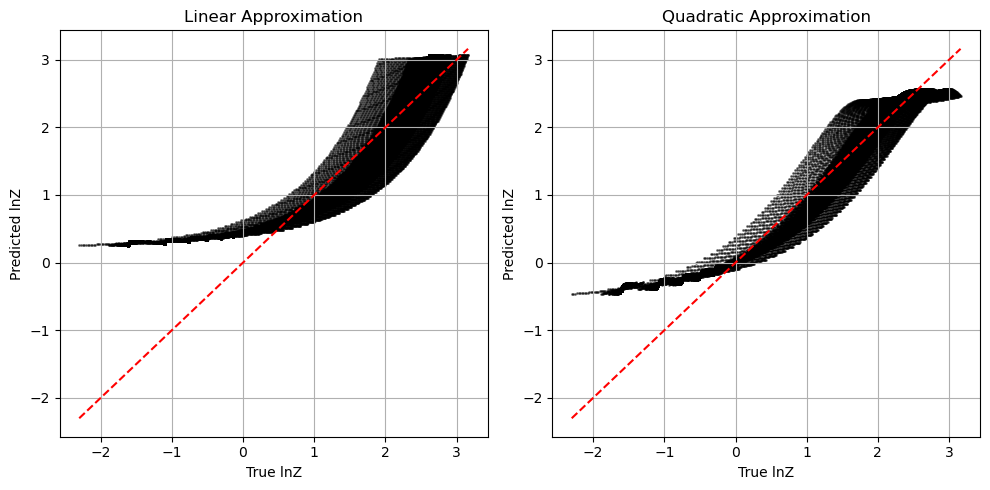

In [6]:

plt.figure(figsize=(10, 5))

# Linear model
plt.subplot(1, 2, 1)
plt.scatter(lnZ, pred_lnZ_linear, s=1, alpha=0.5, c = 'k')
plt.plot([lnZ.min(), lnZ.max()], [lnZ.min(), lnZ.max()], 'r--')
plt.xlabel('True lnZ')
plt.ylabel('Predicted lnZ')
plt.title('Linear Approximation')
plt.grid(True)

# Quadratic model
plt.subplot(1, 2, 2)
plt.scatter(lnZ, pred_lnZ_quad, s=1, alpha=0.5, c = 'k')
plt.plot([lnZ.min(), lnZ.max()], [lnZ.min(), lnZ.max()], 'r--')
plt.xlabel('True lnZ')
plt.ylabel('Predicted lnZ')
plt.title('Quadratic Approximation')
plt.grid(True)

plt.tight_layout()
plt.show()


Percentage of predictions within ±0.3 of true lnZ:
  Linear Model:    64.34%
  Quadratic Model: 95.60%


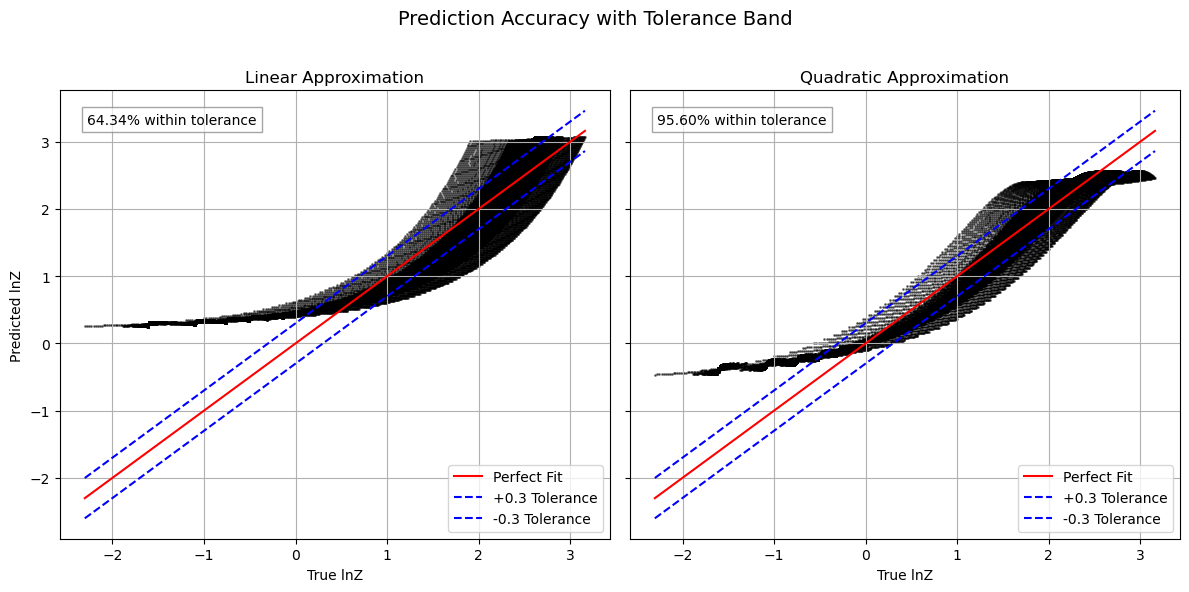

In [7]:
def percent_within_tolerance(true_vals, predicted_vals, tolerance):
    diffs = np.abs(true_vals - predicted_vals)
    within_tol = np.sum(diffs <= tolerance)
    percent = (within_tol / len(true_vals)) * 100
    return percent

# Tolerance value
tolerance = 0.3

# Compute percentages
percent_linear = percent_within_tolerance(lnZ, pred_lnZ_linear, tolerance)
percent_quad = percent_within_tolerance(lnZ, pred_lnZ_quad, tolerance)

print(f"Percentage of predictions within ±{tolerance} of true lnZ:")
print(f"  Linear Model:    {percent_linear:.2f}%")
print(f"  Quadratic Model: {percent_quad:.2f}%")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Common 1:1 line and tolerance band range
x_vals = np.linspace(lnZ.min(), lnZ.max(), 100)

# --- Linear Fit ---
axes[0].scatter(lnZ, pred_lnZ_linear, s=1, alpha=0.5, c='k')
axes[0].plot([lnZ.min(), lnZ.max()], [lnZ.min(), lnZ.max()], 'r', label='Perfect Fit')
axes[0].plot(x_vals, x_vals + tolerance, 'b--', label=f'+{tolerance} Tolerance')
axes[0].plot(x_vals, x_vals - tolerance, 'b--', label=f'-{tolerance} Tolerance')
axes[0].set_title('Linear Approximation')
axes[0].set_xlabel('True lnZ')
axes[0].set_ylabel('Predicted lnZ')
axes[0].legend(loc = 'lower right')
axes[0].grid(True)
axes[0].text(0.05, 0.95, f'{percent_linear:.2f}% within tolerance',
             transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

# --- Quadratic Fit ---
axes[1].scatter(lnZ, pred_lnZ_quad, s=1, alpha=0.5, c='k')
axes[1].plot([lnZ.min(), lnZ.max()], [lnZ.min(), lnZ.max()], 'r', label='Perfect Fit')
axes[1].plot(x_vals, x_vals + tolerance, 'b--', label=f'+{tolerance} Tolerance')
axes[1].plot(x_vals, x_vals - tolerance, 'b--', label=f'-{tolerance} Tolerance')
axes[1].set_title('Quadratic Approximation')
axes[1].set_xlabel('True lnZ')
axes[1].legend(loc = 'lower right')
axes[1].grid(True)
axes[1].text(0.05, 0.95, f'{percent_quad:.2f}% within tolerance',
             transform=axes[1].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.suptitle('Prediction Accuracy with Tolerance Band', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Equation and coefficient for Quadratic approximation:

In [8]:
terms = [
    "e3t", "ssh", "td",
    "e3t^2", "ssh^2", "td^2",
    "e3t*ssh", "e3t*td", "ssh*td"
]
#
coeffs = model_quad.coef_
intercept = model_quad.intercept_
#
print("equation for lnZ ≈")
print(f"  {intercept:.5f} (intercept)")
for term, coef in zip(terms, coeffs):
    print(f"+ {coef:.5f} * {term}")

equation for lnZ ≈
  -0.49404 (intercept)
+ 0.26188 * e3t
+ 0.03542 * ssh
+ -0.00012 * td
+ -0.00578 * e3t^2
+ -0.00046 * ssh^2
+ 0.00000 * td^2
+ -0.00000 * e3t*ssh
+ 0.00000 * e3t*td
+ -0.00011 * ssh*td


In [9]:
coeffs[0]

0.26188025159395323

Explicit equation:

In [10]:
def ln_Z_eq(e3t, ssh, td):
    # coefficients
    a_0 = intercept
    a_1 = coeffs[0]
    a_2 = coeffs[1]
    a_3 = coeffs[2]
    a_4 = coeffs[3]
    a_5 = coeffs[4]
    a_6 = coeffs[5]
    a_7 = coeffs[6]
    a_8 = coeffs[7]
    a_9 = coeffs[8]
    # explicit equation
    EQ = a_0 + a_1 * e3t + a_2 * ssh + a_3 * td + a_4 * e3t**2 + a_5 * ssh**2 + a_6 * td**2
    + a_7 * e3t*ssh + a_8 * e3t*td + a_9 * ssh*td
    # 
    # Truth equation
    Z = e3t * (1 + (ssh / td)) * 0.5
    lnZ_truth = np.log(Z)
    #
    return lnZ_truth, EQ

In [11]:
REAL_lnZ = np.zeros((len(e3t_vals), len(ssh_vals), len(td_vals)))
APPROX_lnZ = np.zeros((len(e3t_vals), len(ssh_vals), len(td_vals)))
for i in range(0, len(e3t_vals)):
    for j in range(0, len(ssh_vals)):
        for k in range(0, len(td_vals)):
            REAL_lnZ[i,j,k], APPROX_lnZ[i,j,k] = ln_Z_eq(e3t_vals[i], ssh_vals[j], td_vals[k])

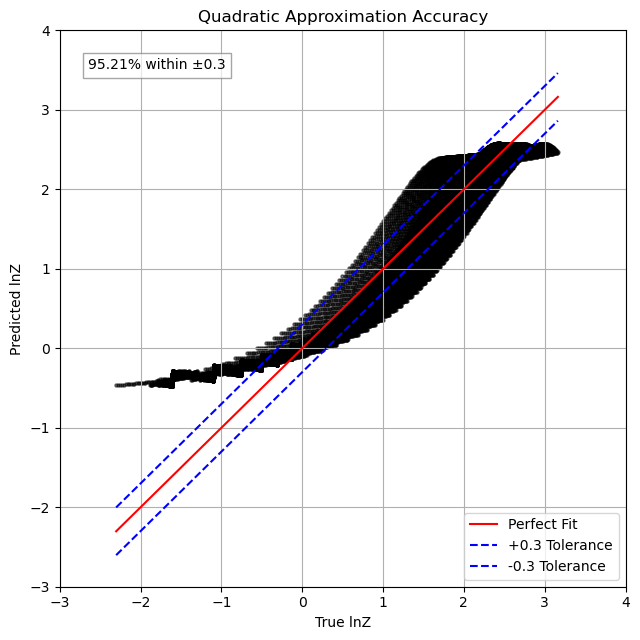

In [12]:
# Flatten values
REAL_lnZ_flat = REAL_lnZ.ravel()
APPROX_lnZ_flat = APPROX_lnZ.ravel()

# Tolerance
tolerance = 0.3
percent_within = percent_within_tolerance(REAL_lnZ_flat, APPROX_lnZ_flat, tolerance)

# Create plot
fig, ax = plt.subplots(figsize=(6.5, 6.5))

# Scatter plot of predictions
ax.scatter(REAL_lnZ_flat, APPROX_lnZ_flat, c='k', s=5, alpha=0.5)

# 1:1 line and tolerance bands
x_vals = np.linspace(min(np.nanmin(REAL_lnZ_flat), np.nanmin(APPROX_lnZ_flat)),max(np.nanmax(REAL_lnZ_flat), np.nanmax(APPROX_lnZ_flat)),100)
ax.plot(x_vals, x_vals, 'r-', label='Perfect Fit')
ax.plot(x_vals, x_vals + tolerance, 'b--', label=f'+{tolerance} Tolerance')
ax.plot(x_vals, x_vals - tolerance, 'b--', label=f'-{tolerance} Tolerance')

# Labels and grid
ax.set_xlabel('True lnZ')
ax.set_ylabel('Predicted lnZ')
ax.set_title('Quadratic Approximation Accuracy')
ax.legend(loc='lower right')
ax.grid(True)

# Percentage text box
ax.text(0.05, 0.95, f'{percent_within:.2f}% within ±{tolerance}',
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
#
ax.set_ylim([-3,4])
ax.set_xlim([-3,4])
#
plt.tight_layout()
plt.show()

Test it with $\tau$ calculation:

In [13]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return timestamps
#
def date_files(date, path, prefix_type= 'grid_T.nc'):
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, folder + f'/SalishSea_1h_{date.strftime("%Y%m%d").lower()}_{date.strftime("%Y%m%d").lower()}_{prefix_type}*')
    file_name = glob.glob(prefix) 
    return file_name
#
# Define a time range (1 day)
begin = datetime(2022,1,1)
end = datetime(2022,1,2)
#end = datetime(2016,3,10)
t_len = (end - begin).days
#
dates = get_timestamps(begin,t_len)

In [14]:
t_len

1

In [15]:
path_days_h = '/results2/SalishSea/nowcast-green.202111/'
files_e3t = []
for i in range(t_len):
    files_e3t.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_T.nc'))
    #
files_U = []
for i in range(t_len):
    files_U.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_U.nc'))
    #
files_V = []
for i in range(t_len):
    files_V.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_V.nc'))

In [16]:
# mbathy to see where is the last grid cell
path_bat = '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc'
bat_file = xr.open_dataset(path_bat)
mbathy = bat_file['mbathy'][0]

Lets remember our equation:

- $u^{*} = \frac{U \cdot k}{ln(\frac{Z}{z^{*}})}$


- $\tau = u^{*2} \cdot \rho$

In [17]:
u_vals = np.linspace(-2, 2, 10)
v_vals = np.linspace(-2, 2, 10)

In [18]:
# Vectorize for avoiding a huge loop
REAL_lnZ_flat = REAL_lnZ_flat.reshape(1, 1, -1)  # Shape (1, 1, 1000000)
APPROX_lnZ_flat = APPROX_lnZ_flat.reshape(1, 1, -1)
# grid of U magnitudes
u_grid, v_grid = np.meshgrid(u_vals, v_vals, indexing='ij')  # Shape (10, 10)
U = np.sqrt(u_grid**2 + v_grid**2).reshape(10, 10, 1)  # Reshape to (10, 10, 1)
#
log_z0 = np.log(0.07)
REAL_tau = (((U * 0.42) / (REAL_lnZ_flat - log_z0)) ** 2) * 1024
PREDICTED_tau = (((U * 0.42) / (APPROX_lnZ_flat - log_z0)) ** 2) * 1024

In [19]:
PREDICTED_tau.shape

(10, 10, 1000000)

In [20]:
U.shape

(10, 10, 1)

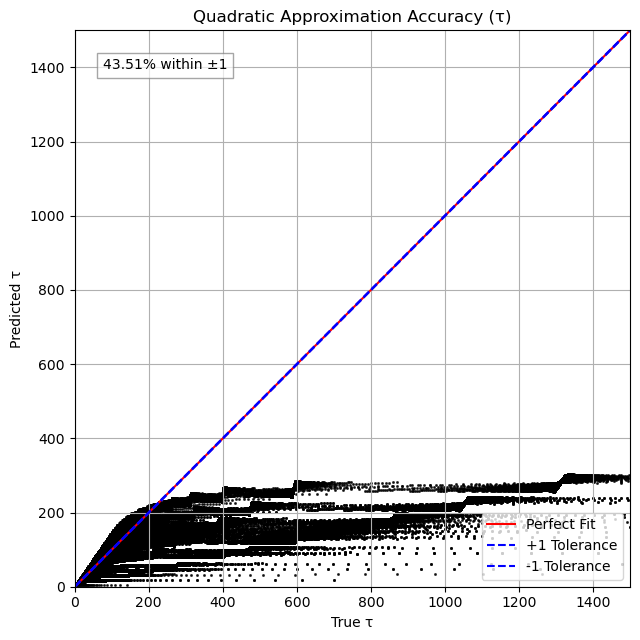

In [21]:
# 
REAL_tau_flat = REAL_tau.ravel()
PREDICTED_tau_flat = PREDICTED_tau.ravel()

# Tolerance value
tolerance = 1  

percent_within = percent_within_tolerance(REAL_tau_flat, PREDICTED_tau_flat, tolerance)

# 
fig, ax = plt.subplots(figsize=(6.5, 6.5))

# 
ax.scatter(REAL_tau_flat, PREDICTED_tau_flat, c='k', s=1, alpha=0.3)

#
x_vals = np.linspace(
    min(np.nanmin(REAL_tau_flat), np.nanmin(PREDICTED_tau_flat)),
    max(np.nanmax(REAL_tau_flat), np.nanmax(PREDICTED_tau_flat)),
    100
)
ax.plot(x_vals, x_vals, 'r-', label='Perfect Fit')
ax.plot(x_vals, x_vals + tolerance, 'b--', label=f'+{tolerance} Tolerance')
ax.plot(x_vals, x_vals - tolerance, 'b--', label=f'-{tolerance} Tolerance')

#
ax.set_xlabel('True τ')
ax.set_ylabel('Predicted τ')
ax.set_title('Quadratic Approximation Accuracy (τ)')
ax.legend(loc='lower right')
ax.grid(True)

# Percentage text box
ax.text(0.05, 0.95, f'{percent_within:.2f}% within ±{tolerance}',
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

#
ax.set_xlim([0,1500])
ax.set_ylim([0,1500])
#
plt.tight_layout()
plt.show()

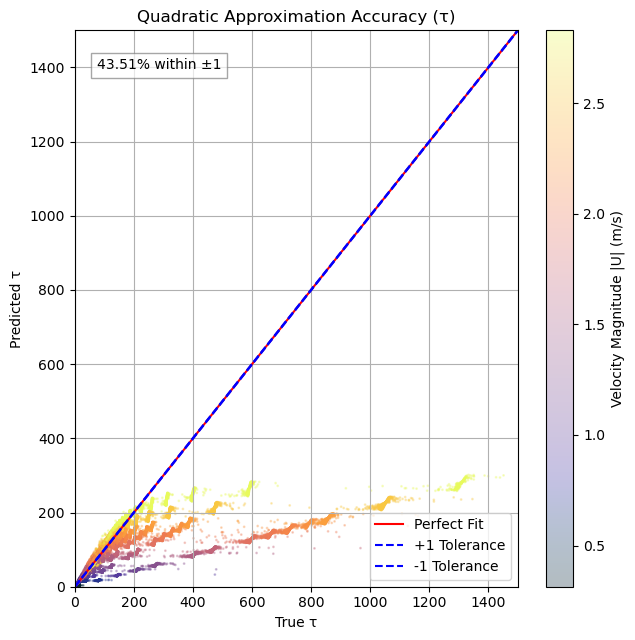

In [22]:
U_flat = U.squeeze().ravel()  # shape (100,)
# U to match shape
U_repeated = np.repeat(U_flat, 1_000_000)  # shape (100_000_000,)

# Downsample for visualization :)
sample_size = 500000
total_size = REAL_tau_flat.size
idx = np.random.choice(total_size, sample_size, replace=False)
# 
fig, ax = plt.subplots(figsize=(6.5, 6.5))

sc = ax.scatter(REAL_tau_flat[idx], PREDICTED_tau_flat[idx], c=U_repeated[idx],
                cmap=cmocean.cm.thermal, s=1, alpha=0.3)

# Colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Velocity Magnitude |U| (m/s)')

# tolerance bands
x_vals = np.linspace(
    min(np.nanmin(REAL_tau_flat), np.nanmin(PREDICTED_tau_flat)),
    max(np.nanmax(REAL_tau_flat), np.nanmax(PREDICTED_tau_flat)),
    100
)
ax.plot(x_vals, x_vals, 'r-', label='Perfect Fit')
ax.plot(x_vals, x_vals + tolerance, 'b--', label=f'+{tolerance} Tolerance')
ax.plot(x_vals, x_vals - tolerance, 'b--', label=f'-{tolerance} Tolerance')
#
ax.set_xlabel('True τ')
ax.set_ylabel('Predicted τ')
ax.set_title('Quadratic Approximation Accuracy (τ)')
ax.legend(loc='lower right')
ax.grid(True)

#
ax.text(0.05, 0.95, f'{percent_within:.2f}% within ±{tolerance}',
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

# 
ax.set_xlim([0, 1500])
ax.set_ylim([0, 1500])

plt.tight_layout()
plt.show()


Conslusion:

This MAY NOT be the best approach, since the error margin is too big for getting accurate values along the simulation

Lets now try to fit log{Z} after defining e3t, ssh and td. Then, try for tau

Taylor Expanssion for ln(x):

- $ln(x) = 2\sum_{0}^{\infty} \frac{((x-1)/(x+1))^{(2n-1)}}{2n-1}$, for x > 0

In [23]:
e3t_vals = np.linspace(0.4, 27, 100)
ssh_vals = np.linspace(-2, 3, 100)
td_vals = np.linspace(4, 430, 100)

E3T, SSH, TD = np.meshgrid(e3t_vals, ssh_vals, td_vals, indexing='ij')

# Flatten them to get a list of all combinations
e3t_flat = E3T.ravel()
ssh_flat = SSH.ravel()
td_flat = TD.ravel()


In [24]:
x_vals = e3t_flat * (1 + (ssh_flat / td_flat)) * 0.5

In [25]:
N = 10
n = np.arange(1, N + 1).reshape(1, -1)  # (1, N)
z = ((x_vals - 1) / (x_vals + 1)).reshape(-1, 1)  # (1_000_000, 1)
terms = 2* (z ** (2 * n - 1)) / (2 * n - 1)
approx = np.sum(terms, axis=1)

In [26]:
true_vals = np.log(x_vals)

In [27]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
r2 = r2_score(true_vals, approx)
rmse = np.sqrt(mean_squared_error(true_vals, approx))
mae = mean_absolute_error(true_vals, approx)
max_error = np.max(np.abs(true_vals - approx))
#
print(f"R² score:          {r2:.6f}")
print(f"RMSE:              {rmse:.6e}")
print(f"Mean Absolute Error: {mae:.6e}")
print(f"Max Absolute Error:  {max_error:.6e}")


R² score:          0.999970
RMSE:              4.858794e-03
Mean Absolute Error: 2.673773e-03
Max Absolute Error:  7.508234e-02


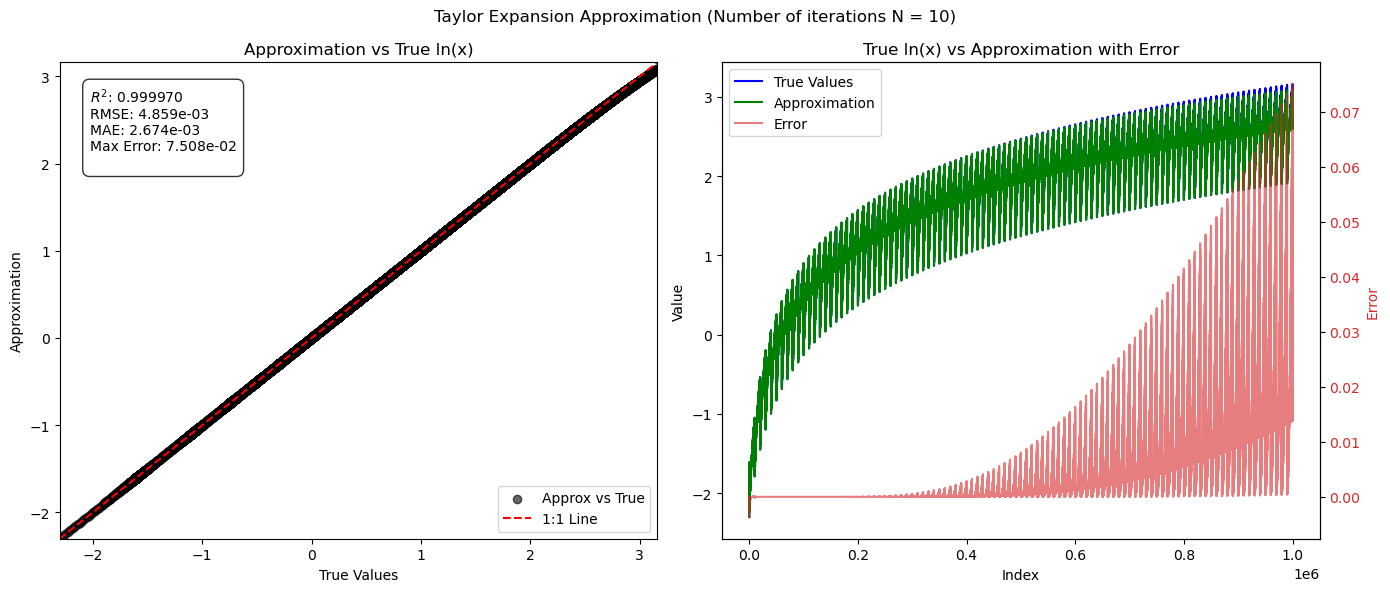

In [28]:
stats_text = (
    f"$R^2$: {r2:.6f}\n"
    f"RMSE: {rmse:.3e}\n"
    f"MAE: {mae:.3e}\n"
    f"Max Error: {max_error:.3e}\n"
)

# error
error = true_vals - approx
indices = np.arange(len(true_vals))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.scatter(true_vals, approx, alpha=0.6, color='k', label='Approx vs True')
min_val = min(np.min(true_vals), np.min(approx))
max_val = max(np.max(true_vals), np.max(approx))
ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_xlabel("True Values")
ax.set_ylabel("Approximation")
ax.set_title("Approximation vs True ln(x)")
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
ax.legend(loc='lower right')

ax2 = axes[1]
ax2.plot(indices, true_vals, label='True Values', color='b')
ax2.plot(indices, approx, label='Approximation', color='g')
ax2.set_xlabel("Index")
ax2.set_ylabel("Value")
ax2.set_title("True ln(x) vs Approximation with Error")

ax2_err = ax2.twinx()
ax2_err.plot(indices, error, label='Error', color='tab:red', alpha=0.6)
ax2_err.set_ylabel("Error", color='tab:red')
ax2_err.tick_params(axis='y', labelcolor='tab:red')

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_err.get_legend_handles_labels()
ax2_err.legend(lines + lines2, labels + labels2, loc='upper left')
#
plt.suptitle(f'Taylor Expansion Approximation (Number of iterations N = {N})')

plt.tight_layout()
plt.show()

Lets see Tau

In [29]:
u_vals = np.linspace(-2, 2, 10)
v_vals = np.linspace(-2, 2, 10)

In [30]:
approx.shape

(1000000,)

In [ ]:
x_vals

0.5264097537406413

In [31]:
# Vectorize for avoiding a huge loop
true_lnZ_flat = true_vals.reshape(1, 1, -1)  # Shape (1, 1, 1000000)
approx_lnZ_flat = approx.reshape(1, 1, -1)
# grid of U magnitudes
u_grid, v_grid = np.meshgrid(u_vals, v_vals, indexing='ij')  # Shape (10, 10)
U = np.sqrt(u_grid**2 + v_grid**2).reshape(10, 10, 1)  # Reshape to (10, 10, 1)
#
log_z0 = np.log(0.07)
real_tau = (((U * 0.42) / (true_lnZ_flat - log_z0)) ** 2) * 1024
approx_tau = (((U * 0.42) / (approx_lnZ_flat - log_z0)) ** 2) * 1024

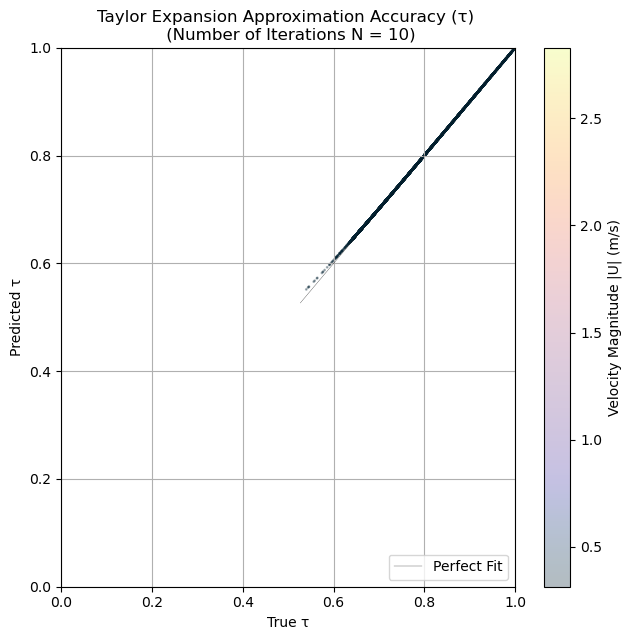

In [33]:
true_tau_flat = real_tau.ravel()
approx_tau_flat = approx_tau.ravel()
U_flat = U.squeeze().ravel()  # shape (100,)
# U to match shape
U_repeated = np.repeat(U_flat, 1_000_000)  # shape (100_000_000,)

# Downsample for visualization :)
sample_size = 500000
total_size = true_tau_flat.size
idx = np.random.choice(total_size, sample_size, replace=False)
# 
fig, ax = plt.subplots(figsize=(6.5, 6.5))

sc = ax.scatter(true_tau_flat[idx], approx_tau_flat[idx], c=U_repeated[idx],
                cmap=cmocean.cm.thermal, s=1, alpha=0.3)

# Colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Velocity Magnitude |U| (m/s)')

# tolerance bands
x_vals = np.linspace(
    min(np.nanmin(true_tau_flat), np.nanmin(approx_tau_flat)),
    max(np.nanmax(true_tau_flat), np.nanmax(approx_tau_flat)),
    100
)
ax.plot(x_vals, x_vals, 'k-', label='Perfect Fit', linewidth = 0.2)
#ax.plot(x_vals, x_vals + tolerance, 'b--', label=f'+{tolerance} Tolerance')
#ax.plot(x_vals, x_vals - tolerance, 'b--', label=f'-{tolerance} Tolerance')
#
ax.set_xlabel('True τ')
ax.set_ylabel('Predicted τ')
ax.set_title(f'Taylor Expansion Approximation Accuracy (τ) \n (Number of Iterations N = {N})')
ax.legend(loc='lower right')
ax.grid(True)

#
#ax.text(0.05, 0.95, f'{percent_within:.2f}% within ±{tolerance}',
#        transform=ax.transAxes, fontsize=10,
#        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

# 
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()